In [1]:
#use an appropriate version of python (3.9.13 is what I used), as that is geared exclusively for this package now and doesn't have numpy

#pip install SquidstatPyLibrary-1.9.1.8-py3-none-win_amd64.whl

In [2]:
%gui qt

import sys
import struct
import time
import pandas as pd
from PySide6.QtWidgets import QApplication
from PySide6.QtCore import QEventLoop
from SquidstatPyLibrary import AisDeviceTracker
from SquidstatPyLibrary import AisCompRange
from SquidstatPyLibrary import AisDCData
from SquidstatPyLibrary import AisExperimentNode
from SquidstatPyLibrary import AisErrorCode
from SquidstatPyLibrary import AisExperiment, AisDCPotentialSweepElement
import numpy as np


from SquidstatPyLibrary import AisConstantPotElement
from SquidstatPyLibrary import AisCyclicVoltammetryElement
from SquidstatPyLibrary import AisConstantCurrentElement
from SquidstatPyLibrary import (
    AisDeviceTracker, AisCompRange, AisDCData, AisACData, AisExperimentNode,
    AisErrorCode, AisExperiment, AisInstrumentHandler, AisConstantCurrentElement, AisCyclicVoltammetryElement, AisErrorCode, AisExperiment
)
import matplotlib.pyplot as plt

app = QApplication.instance() or QApplication(sys.argv)
tracker = AisDeviceTracker.Instance()
tracker.connectToDeviceOnComPort("COM7")
#check COM port in device manager

In [3]:
device = 'Prime2645'

#this is the potentiostat you have at hand. Please check the model and serial number and enter that here

In [4]:
def record_cv_multi(deviceName, cv_params_list, repeat=3):
    """
    Run cyclic voltammetry experiments on multiple channels.
    
    Parameters:
      - deviceName: name of the instrument
      - cv_params_list: list of tuples, each tuple containing:
            (start, low, high, end, step, sampling_interval)
            One tuple per channel (up to 4 channels).
      - repeat: number of repeats for each experiment.
    
    Returns:
      A dictionary mapping channel indices to a pandas DataFrame containing the recorded data.
    """
    print(f"Device is Connected: {deviceName}")
    handler = tracker.getInstrumentHandler(deviceName)

    # Disconnect previous signal connections to avoid duplicates.
    for sig in ['activeDCDataReady', 'experimentNewElementStarting', 'experimentStopped']:
        try:
            getattr(handler, sig).disconnect()
        except Exception:
            pass

    # Prepare a dictionary to collect data for each channel.
    records_by_channel = {ch: [] for ch in range(len(cv_params_list))}

    # Connect a global signal to collect data, routing by channel.
    handler.activeDCDataReady.connect(
        lambda channel, data: records_by_channel[channel].append({
            'timestamp': round(data.timestamp, 3),
            'voltage': round(data.counterElectrodeVoltage, 9),
            'working_electrode_voltage': round(data.workingElectrodeVoltage, 9),
            'counter_electrode_voltage': round(data.counterElectrodeVoltage, 9),
            'current': round(data.current, 9)
        })
    )

    # Optional: print new node events.
    handler.experimentNewElementStarting.connect(
        lambda channel, data: print(f"Channel {channel} - New Node: {data.stepName}, step {data.stepNumber}, sub {data.substepNumber}")
    )

    # Use a local event loop to wait until all experiments finish.
    loop = QEventLoop()
    completed_channels = set()

    def on_experiment_stopped(channel):
        print(f"Channel {channel} - Experiment Completed")
        completed_channels.add(channel)
        if len(completed_channels) == len(cv_params_list):
            loop.quit()

    handler.experimentStopped.connect(on_experiment_stopped)

    # For each channel, create the experiment and upload it.
    for ch, params in enumerate(cv_params_list):
        start, low, high, end, step, sampling_interval = params
        experiment = AisExperiment()
        cyclic = AisCyclicVoltammetryElement(start, low, high, end, step, sampling_interval)
        subExperiment = AisExperiment()
        subExperiment.appendElement(cyclic)
        experiment.appendSubExperiment(subExperiment, repeat)
        
        error = handler.uploadExperimentToChannel(ch, experiment)
        if error.value() != AisErrorCode.Success:
            print(f"Error uploading experiment on channel {ch}: {error.message()}")
            return None

    # Start experiments on all channels.
    for ch in range(len(cv_params_list)):
        error = handler.startUploadedExperiment(ch)
        if error.value() != AisErrorCode.Success:
            print(f"Error starting experiment on channel {ch}: {error.message()}")
            return None

    # Wait until all channels have finished their experiments.
    loop.exec()

    # Create a DataFrame for each channel.
    dfs = {ch: pd.DataFrame(records_by_channel[ch]) for ch in records_by_channel}
    return dfs

In [5]:
# Example usage: run CV experiments on two channels with different parameters.
# Each tuple: (start, low, high, end, step, sampling_interval)
cv_params = [
    (0, -0.25, 0.25, 0.25, 0.1, 0.01),  # For channel 0
    (0, -0.15, 0.15, 0.15, 0.1, 0.01)   # For channel 1
    # Add up to 4 tuples for channels 0-3 as needed.
]

dfs = record_cv_multi(device, cv_params, repeat=1)

Device is Connected: Prime2645
Channel 0 - New Node: Cyclic Voltammetry, step 1, sub 1
Channel 1 - New Node: Cyclic Voltammetry, step 1, sub 1
Channel 1 - Experiment Completed
Channel 0 - Experiment Completed


In [6]:
#this splits the dataframes returned in the previous line in the form of a dictionary into two distinct dataframes 

for ch, df in dfs.items():
    var_name = f"df{ch+1}"  # Creates df1, df2, etc.
    globals()[var_name] = df  # Assigns the DataFrame to the new variable
    #print(f"Created {var_name} for channel {ch}:")
    #print(df.head())

In [7]:
df1

,timestamp,voltage,working_electrode_voltage,counter_electrode_voltage,current
0,0.058,-0.000052,-0.001728,-0.000052,-0.000277
1,0.068,0.000011,-0.002924,0.000011,-0.000283
2,0.078,0.000003,-0.003923,0.000003,-0.000289
3,0.088,0.000089,-0.004946,0.000089,-0.000295
4,0.098,-0.000024,-0.005930,-0.000024,-0.000300
...,...,...,...,...,...
747,7.475,0.000185,0.245814,0.000185,0.001109
748,7.485,0.000174,0.246828,0.000174,0.001115
749,7.495,0.000197,0.247841,0.000197,0.001120
750,7.505,0.000146,0.248855,0.000146,0.001126


In [8]:
df2

,timestamp,voltage,working_electrode_voltage,counter_electrode_voltage,current
0,0.058,-0.000011,0.003036,-0.000011,0.000270
1,0.068,0.000038,-0.003097,0.000038,0.000253
2,0.078,0.000004,-0.004086,0.000004,0.000249
3,0.088,0.000015,-0.005091,0.000015,0.000245
4,0.098,-0.000044,-0.006145,-0.000044,0.000240
...,...,...,...,...,...
446,4.488,0.000033,0.069874,0.000033,0.000577
447,4.498,-0.000012,0.069805,-0.000012,0.000577
448,4.508,0.000053,0.069914,0.000053,0.000577
449,4.518,-0.000007,0.069830,-0.000007,0.000577


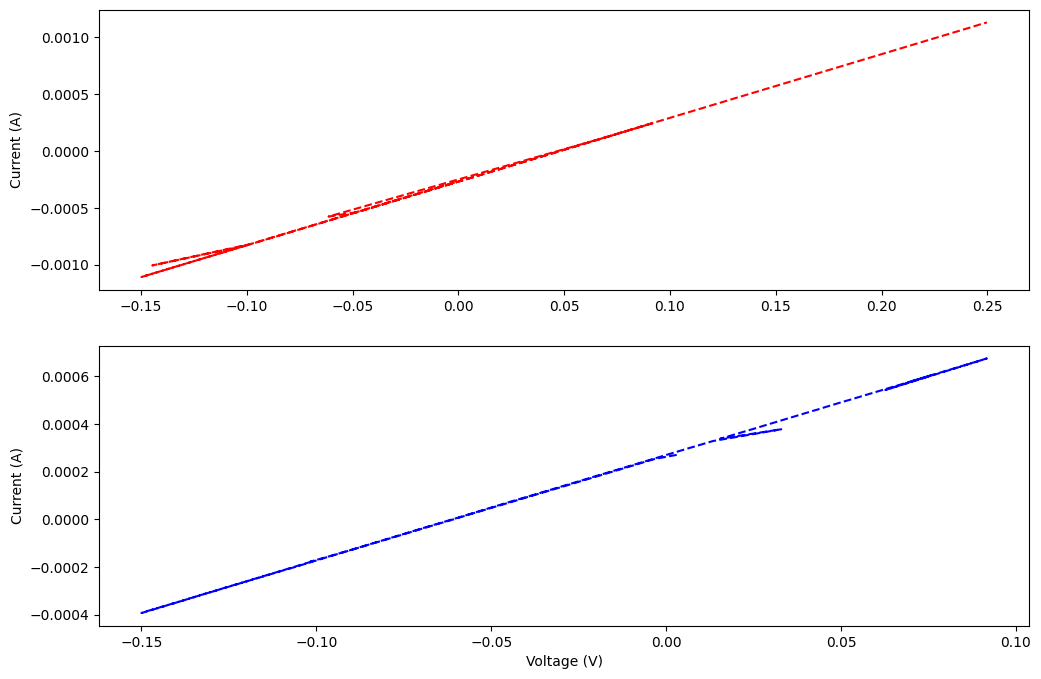

In [9]:
plt.figure(figsize= (12, 8))
plt.subplot(211)
plt.plot(df1['working_electrode_voltage'], df1['current'], 'r--')
plt.ylabel('Current (A)')

plt.subplot(212)
plt.plot(df2['working_electrode_voltage'], df2['current'], 'b--')
plt.ylabel('Current (A)')
plt.xlabel('Voltage (V)')

plt.show()

#we plot the dataframes here to see the difference between the two sets of measurements for testing

In [10]:
def cp_mode_multi(deviceName, cp_params_list, repeat=1):
    """
    Run constant current experiments on multiple channels.
    
    Parameters:
      deviceName: e.g. "Prime2645"
      cp_params_list: list of tuples (current, duration, sampling_interval)
                      One tuple per channel (maximum of 4 channels).
      repeat: number of repeats for each experiment.
    
    Returns:
      A dictionary mapping channel indices (0,1,2,...) to a pandas DataFrame 
      containing the collected data for that channel.
    """
    print(f"Expected experiment time = {max(duration for current, duration, sampling_interval in cp_params_list) * repeat} s")
    print(f"Device is Connected: {deviceName}")
    
    handler = tracker.getInstrumentHandler(deviceName)
    
    # Disconnect previous signal connections to avoid duplicates.
    for signal in ['activeDCDataReady', 'experimentNewElementStarting', 'experimentStopped']:
        try:
            getattr(handler, signal).disconnect()
        except Exception:
            pass
    
    # Create a dictionary to store records per channel.
    records_by_channel = { ch: [] for ch in range(len(cp_params_list)) }
    
    # Collect data per channel.
    handler.activeDCDataReady.connect(
        lambda channel, data: records_by_channel[channel].append({
            'timestamp': round(data.timestamp, 3),
            'working_electrode_voltage': round(data.workingElectrodeVoltage, 9),
            'counter_electrode_voltage': round(data.counterElectrodeVoltage, 9),
            'current': round(data.current, 9)
        })
    )
    
    # Optional: print new node events.
    handler.experimentNewElementStarting.connect(
        lambda channel, data: print(f"Channel {channel} - New Node: {data.stepName}, step {data.stepNumber}, sub {data.substepNumber}")
    )
    
    # Use a local event loop to wait until all channels finish.
    loop = QEventLoop()
    completed_channels = set()
    
    def on_experiment_stopped(channel):
        print(f"Channel {channel} - Experiment Completed")
        completed_channels.add(channel)
        if len(completed_channels) == len(cp_params_list):
            loop.quit()
    
    handler.experimentStopped.connect(on_experiment_stopped)
    
    # For each channel, create and upload the experiment.
    for ch, params in enumerate(cp_params_list):
        current, duration, sampling_interval = params
        experiment = AisExperiment()
        ccElement = AisConstantCurrentElement(current, sampling_interval, duration)
        subExperiment = AisExperiment()
        subExperiment.appendElement(ccElement)
        experiment.appendSubExperiment(subExperiment, repeat)
        
        error = handler.uploadExperimentToChannel(ch, experiment)
        if error.value() != AisErrorCode.Success:
            print(f"Error uploading experiment on channel {ch}: {error.message()}")
            return None
    
    # Start the experiment on each channel.
    for ch in range(len(cp_params_list)):
        error = handler.startUploadedExperiment(ch)
        if error.value() != AisErrorCode.Success:
            print(f"Error starting experiment on channel {ch}: {error.message()}")
            return None

    # Block until all experiments are completed.
    loop.exec()
    
    # Convert the collected records into DataFrames for each channel.
    dfs = { ch: pd.DataFrame(records_by_channel[ch]) for ch in records_by_channel }
    return dfs

In [11]:
cp_params = [
    (0.01, 10, 1),   # Channel 0
    (0.025, 25, 1)    # Channel 1
    # You can include up to 4 tuples for channels 0-3.
]

dfs_cp = cp_mode_multi("Prime2645", cp_params, repeat=1)

for ch, df_cp in dfs_cp.items():
    var_name = f"df_cp{ch+1}"  # Creates df1, df2, etc.
    globals()[var_name] = df_cp  # Assigns the DataFrame to the new variable
    #print(f"Created {var_name} for channel {ch}:")
    #print(df.head())

Expected experiment time = 25 s
Device is Connected: Prime2645
Channel 0 - New Node: Constant Current, step 1, sub 1
Channel 1 - New Node: Constant Current, step 1, sub 1
Channel 0 - Experiment Completed
Channel 1 - Experiment Completed


In [12]:
df_cp1

,timestamp,working_electrode_voltage,counter_electrode_voltage,current
0,1.000,3.489977,0.000087,0.009990
1,2.000,3.490865,0.000076,0.009992
2,3.000,3.491201,0.000105,0.009992
3,4.001,3.491387,0.000110,0.009992
4,5.001,3.491535,0.000099,0.009992
5,6.001,3.491621,0.000078,0.009992
6,7.001,3.491657,0.000079,0.009992
7,8.001,3.491779,0.000117,0.009993
8,9.001,3.491789,0.000121,0.009993
9,10.000,3.491871,0.000120,0.009993


In [13]:
df_cp2

,timestamp,working_electrode_voltage,counter_electrode_voltage,current
0,1.000,3.489837,-0.000126,0.024960
1,2.000,3.490746,-0.000081,0.024964
2,3.000,3.491080,-0.000081,0.024965
3,4.001,3.491242,-0.000095,0.024966
4,5.001,3.491402,-0.000138,0.024966
5,6.001,3.491495,-0.000081,0.024966
6,7.001,3.491534,-0.000083,0.024966
7,8.001,3.491618,-0.000118,0.024966
8,9.001,3.491672,-0.000126,0.024967
9,10.001,3.491378,-0.000110,0.024971
